<a href="https://colab.research.google.com/github/duongtrung/Pytorch-tutorials/blob/main/15_pytorch_multivariate_timeseries_forecasting_LSTM_v1_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

In [1]:
# dataset: https://finance.yahoo.com/quote/GE/history/
# select Max in the Time Period if you want to get all datasets until your current date

In [39]:
# General design
# One-step-ahead
# Multivariate

In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

In [41]:
df = pd.read_csv("data/GE-3months.csv")

In [42]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-27,107.879997,108.279999,103.690002,103.849998,103.414063,8984300
1,2021-10-28,103.389999,105.379997,103.099998,105.260002,104.818161,5910800
2,2021-10-29,104.949997,105.239998,104.120003,104.870003,104.429794,5618700
3,2021-11-01,105.760002,106.769997,105.279999,106.230003,105.784088,4887100
4,2021-11-02,106.339996,107.139999,105.300003,106.690002,106.242149,4480800


In [43]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,83.730675,84.845635,82.511746,83.657143,83.445877,6.696986e+06
std,13.882652,13.905495,13.732063,13.747321,13.627205,2.945638e+06
min,61.000000,61.160000,59.930000,61.090000,61.014286,3.269000e+06
25%,72.885000,73.830000,71.139999,72.725000,72.679544,4.980125e+06
50%,80.029999,81.525002,79.110000,80.509998,80.314315,6.147600e+06
75%,94.945001,96.064999,93.650002,94.922501,94.610777,7.606150e+06
max,114.730003,116.169998,110.480003,111.290001,110.822838,2.875490e+07


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [45]:
# separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

In [46]:
train_dates.head(5)

0   2021-10-27
1   2021-10-28
2   2021-10-29
3   2021-11-01
4   2021-11-02
Name: Date, dtype: datetime64[ns]

In [47]:
# variables for training
cols = list(df)[1:3] # ['Open', 'High', 'Low', 'Close', 'Adj Close']

In [48]:
df_for_training = df[cols].astype(float)

<AxesSubplot:>

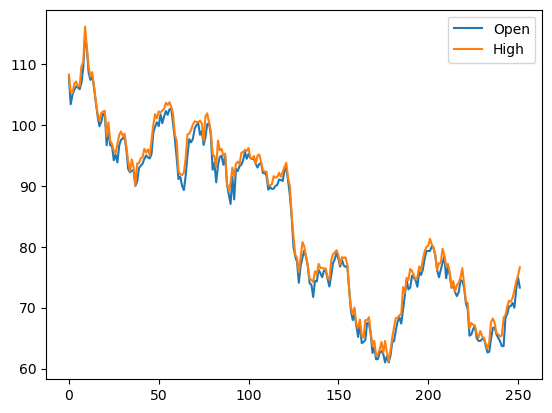

In [49]:
df_for_training.plot.line()

In [13]:
scaler =  StandardScaler() #RobustScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [14]:
df_for_training_scaled.shape

(252, 1)

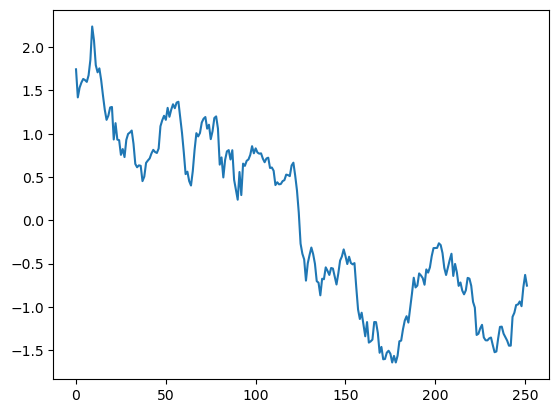

In [15]:
plt.plot(df_for_training_scaled)
plt.show()

In [16]:
np.savetxt("data/GE_3months_scaled.csv", df_for_training_scaled, delimiter=',')

In [17]:
##splitting dataset into train and test split for time series data
training_size = int(len(df_for_training_scaled)*0.65)
test_size = len(df_for_training_scaled)-training_size
train_data,test_data = df_for_training_scaled[0:training_size,:], df_for_training_scaled[training_size:len(df_for_training_scaled),:]

In [18]:
train_data.shape, test_data.shape

((163, 1), (89, 1))

In [19]:
train_data[0], test_data[0]

(array([1.74299417]), array([-1.41108355]))

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
past_observation = 10

In [22]:
class SequenceDataset(Dataset):
    def __init__(self,data,past_len = past_observation):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.past_len = past_len
        
    def __len__(self):
        return len(self.data)-self.past_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.past_len] , self.data[index+self.past_len]


train_dataset = SequenceDataset(train_data, past_len=past_observation) 
test_dataset = SequenceDataset(test_data, past_len=past_observation) 

In [23]:
len(train_dataset)

152

In [24]:
train_dataset[0]

(tensor([1.7430, 1.4189, 1.5315, 1.5900, 1.6318, 1.6189, 1.5979, 1.6744, 1.8527,
         2.2374]),
 tensor(2.0764))

In [25]:
train_dataset[1]

(tensor([1.4189, 1.5315, 1.5900, 1.6318, 1.6189, 1.5979, 1.6744, 1.8527, 2.2374,
         2.0764]),
 tensor(1.7914))

In [26]:
train_dataset[2]

(tensor([1.5315, 1.5900, 1.6318, 1.6189, 1.5979, 1.6744, 1.8527, 2.2374, 2.0764,
         1.7914]),
 tensor(1.7084))

In [27]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size , drop_last=True)

In [28]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size = hidden_size, num_layers= num_layers, dropout=0, bidirectional=False)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn)) # out shape (past observation, batch_size, hidden_size)
        final_out = self.fc(out[-1])   # out[-1].shape: torch.Size([batch_size, hidden_size])
        return final_out,hn,cn # final_out.shape: [batch_size,1]

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])  
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0

In [29]:
input_dim = 1
hidden_size = 30
num_layers = 5

In [30]:
model = Lstm_model(input_dim , hidden_size , num_layers).to(device)

In [31]:
from torchsummary import summary
summary(model, verbose=0)

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              33,720
├─Linear: 1-2                            31
Total params: 33,751
Trainable params: 33,751
Non-trainable params: 0

In [32]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [33]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    losses = []
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(past_observation,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        losses.append(loss.item())
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_train = np.sum(losses) / len(dataloader)
    #print(f"train loss: {loss_train:>8f} ")
    return loss_train 

In [34]:
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    losses = []
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(past_observation,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        losses.append(loss.item())
       
    loss_test = np.sum(losses) / len(dataloader)
    #print(f"test loss: {loss_test:>8f} ")
    return loss_test

In [35]:
epochs = 50
train_losses = []
test_losses = []
for epoch in range(epochs):
    train_losses.append(train(train_dataloader))
    test_losses.append(test(test_dataloader))
    if epoch % 5 == 0:
        print(f"epoch {epoch} ")
        print(train_losses[epoch], test_losses[epoch])

epoch 0 
0.6774620929438817 1.3764272881181616
epoch 5 
0.5722047900290865 1.740181127661153
epoch 10 
0.37104711485536473 1.5881568820852983
epoch 15 
0.26515252520575333 1.2695546087465788
epoch 20 
0.19442685830749964 0.9305855245574525
epoch 25 
0.12823461627244556 0.4894234663071601
epoch 30 
0.10769088382489587 0.28163588645034715
epoch 35 
0.10581463869465024 0.269152034123085
epoch 40 
0.11328963769636557 0.26971274812852863
epoch 45 
0.10818150522505962 0.27169708522820946


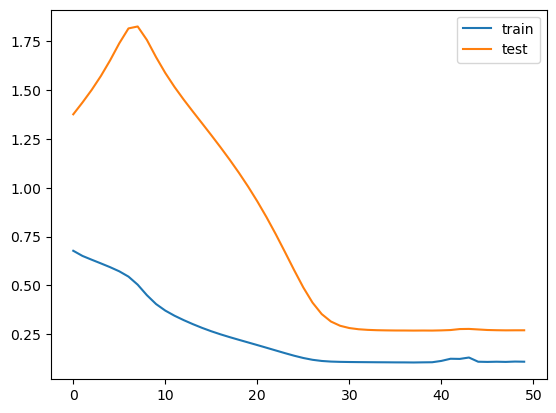

In [36]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

In [37]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(past_observation,batch_size,1)
            pred = model(x,hn,cn)[0]
            pred = scaler.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scaler.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        #print(pred_arr[21],y_arr[21])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))

In [38]:
# calculating final loss metrics
print("final loss metrics after inversing scaling")
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

final loss metrics after inversing scaling
train mse loss 6.071766172367337
test mse loss 8.497458133981569
